In [1]:
# read the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

grid = pd.read_pickle("outputs_in_instab_strip.pkl")

In [2]:
print(grid.columns)

Index(['F_l_0', 'F_l_1', 'F_l_2', 'O1_l_0', 'O1_l_1', 'O1_l_2', 'O2_l_0',
       'O2_l_1', 'O2_l_2', 'O3_l_0', 'O3_l_1', 'O3_l_2', 'O4_l_0', 'O4_l_1',
       'O4_l_2', 'O5_l_0', 'O5_l_1', 'O5_l_2', 'O6_l_0', 'O6_l_1', 'O6_l_2',
       'O7_l_0', 'O7_l_1', 'O7_l_2', 'O8_l_0', 'O8_l_1', 'O8_l_2', 'O9_l_0',
       'O9_l_1', 'O9_l_2', 'delta_nu'],
      dtype='object')


In [3]:
# then we have to first create the X and y matrices.

l_values = [0, 1, 2] 
l_columns = {l: [col for col in grid.columns if col.endswith(f"_l_{l}")] for l in l_values}

X_frequencies = np.hstack([grid[l_columns[l]].values for l in l_values])  
delta_nu_values = grid["delta_nu"].values[:, np.newaxis] 
mod_frequencies = X_frequencies % delta_nu_values 

X = np.stack((X_frequencies, mod_frequencies), axis=-1)
y = np.hstack([np.full_like(grid[l_columns[l]].values, l) for l in l_values])  

print(f"X-matrix shape: {X.shape}")
print(f"y-matrix shape: {y.shape}") 

X-matrix shape: (153314, 30, 2)
y-matrix shape: (153314, 30)


In [4]:
from sklearn.model_selection import train_test_split
import torch

# Convert data to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)  # Assuming y contains class labels

# Split the data (80% train, 10% val, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print shape
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Train: torch.Size([122651, 30, 2]), Validation: torch.Size([15331, 30, 2]), Test: torch.Size([15332, 30, 2])


In [5]:
size = 10000 # or for all models it would be: X_train.shape[0]
inpt = X_train[:size]
print(inpt.shape)

torch.Size([10000, 30, 2])


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class PointNet(nn.Module):
    def __init__(self, num_classes=3, point_dimension=2, dropout=0.3):
        super(PointNet, self).__init__()

        a = 5
        nfeat = 128 

        self.conv_1_a = nn.Conv1d(1, nfeat, kernel_size=a, padding=2)
        self.conv_1_b = nn.Conv1d(1, nfeat, kernel_size=a, padding=2)
        self.conv_2 = nn.Conv1d(nfeat, nfeat, kernel_size=a, padding=2)
        self.bn_1 = nn.BatchNorm1d(nfeat)
        self.bn_2 = nn.BatchNorm1d(nfeat)

    def forward(self, x, plot=False):
        batch_size, num_points, _ = x.shape 
        x_freq = x[:, :, 0].unsqueeze(1) 
        x_modnu = x[:, :, 1].unsqueeze(1)

        x_freq = F.pad(x_freq, (1, 1), mode='replicate')
        x_modnu = F.pad(x_modnu, (1, 1), mode='circular')

        x_freq_feat = self.conv_1_a(x_freq) 
        x_modnu_feat = self.conv_1_b(x_modnu) 

        x = x_freq_feat + x_modnu_feat
        x = F.relu(self.bn_1(x))
        x = F.relu(self.bn_2(self.conv_2(x)))

        x = nn.MaxPool1d(num_points)(x) 
        x = x.view(batch_size, -1)  

        return x
        
class SegmentationPointNet(nn.Module):
    def __init__(self, num_classes, point_dimension=2, dropout=0.3):
        super(SegmentationPointNet, self).__init__()
        self.base_pointnet = PointNet(point_dimension=point_dimension)

        nhidden = 16
        nfeat = 128 
        
        self.fc_1 = nn.Linear(nfeat+2, nhidden)
        self.fc_2 = nn.Linear(nhidden, 3)

    def forward(self, x):
        global_features = self.base_pointnet(x) 
        global_features = global_features.unsqueeze(1) 
        global_features = global_features.repeat(1, x.shape[1], 1)
        x = torch.cat((x, global_features), dim=2) 
        x = F.relu(self.fc_1(x)) 

        return F.log_softmax(self.fc_2(x), dim=2)

In [7]:
model = SegmentationPointNet(num_classes=3, point_dimension=2)
loss = nn.NLLLoss()

In [8]:
out = model(inpt)

# new stuff with data dropper

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F



def apply_data_dropper(x, y, dropout_prob=0.5):
    """
    Randomly drops input points (zeroing them out) with given probability.
    WITHOUT modifying the labels.
    Returns: x_dropped, mask, drop_stats
    """
    # Create binary mask: 1 = keep, 0 = drop
    mask = (torch.rand_like(x[:, :, 0]) > dropout_prob).long()
    
    x_dropped = x.clone() # copy original tensor instead of modifying the original one
    x_dropped[mask == 0] = 0.0 # THIS IS where the dropout is applied, because if mask is 0.0, then we drop!

    # same shablam for the labels!
    y_dropped = y.clone()
    y_dropped[mask == 0] = -1  # ok well here we mark the dropped labels that we want to ignore

    drop_stats = mask.shape[1] - mask.sum(dim=1) # how many points were dropped per sample in the batch?
    # so mask.sum(dim=1) gives us the number of points kept in the sample because it sums over the 2nd dim (num_points)
    
    return x_dropped, y_dropped, mask, drop_stats


Nepoch = 150
nbatches = 100
learning_rate = 0.001
batch_size = inpt.size(0) // nbatches

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss(reduction="mean", ignore_index=-1)

history_train, history_test = [], []

# Data to evaluate on after each epoch
inpt_test = inpt
target_test = y_train[:inpt.shape[0]]
all_drop_counts = []


for epoch in range(Nepoch):
    model.train()
    
    for i in range(nbatches):
        optimizer.zero_grad()

        # Get the batch
        x_batch = inpt[i*batch_size:(i+1)*batch_size]
        y_batch = y_train[i*batch_size:(i+1)*batch_size]

        # Apply data dropper to inputs only
        x_dropped, y_dropped, mask, drop_stats = apply_data_dropper(x_batch, y_batch, dropout_prob=0.5)
        all_drop_counts.extend(drop_stats.cpu().tolist())

        # Forward pass
        seg_output = model(x_dropped)

        # Loss using original labels
        cost = loss_fn(seg_output.permute(0, 2, 1), y_dropped) 

        cost.backward()
        optimizer.step()

    # Evaluation on whole input
    model.eval()
    with torch.no_grad():
        seg_out_test = model(inpt)
        cost_test = loss_fn(seg_out_test.permute(0, 2, 1), y_train[:inpt.shape[0]])

    history_train.append(float(cost))
    history_test.append(float(cost_test))

    print(f"Epoch {epoch}: Train Loss = {cost:.4f}, Test Loss = {cost_test:.4f}")

Epoch 0: Train Loss = 1.0543, Test Loss = 1.1165
Epoch 1: Train Loss = 1.0088, Test Loss = 1.0750
Epoch 2: Train Loss = 0.9728, Test Loss = 1.0214
Epoch 3: Train Loss = 0.9351, Test Loss = 1.0068
Epoch 4: Train Loss = 0.9089, Test Loss = 0.9546
Epoch 5: Train Loss = 0.8810, Test Loss = 0.9138
Epoch 6: Train Loss = 0.8445, Test Loss = 0.8786
Epoch 7: Train Loss = 0.8399, Test Loss = 0.8536
Epoch 8: Train Loss = 0.8076, Test Loss = 0.8287
Epoch 9: Train Loss = 0.7731, Test Loss = 0.8117
Epoch 10: Train Loss = 0.7792, Test Loss = 0.7918
Epoch 11: Train Loss = 0.7476, Test Loss = 0.7833
Epoch 12: Train Loss = 0.7344, Test Loss = 0.7641
Epoch 13: Train Loss = 0.7182, Test Loss = 0.7575
Epoch 14: Train Loss = 0.7098, Test Loss = 0.7353
Epoch 15: Train Loss = 0.6770, Test Loss = 0.7294
Epoch 16: Train Loss = 0.6638, Test Loss = 0.7063
Epoch 17: Train Loss = 0.6372, Test Loss = 0.7022
Epoch 18: Train Loss = 0.6387, Test Loss = 0.6867
Epoch 19: Train Loss = 0.6282, Test Loss = 0.6910
Epoch 20: 

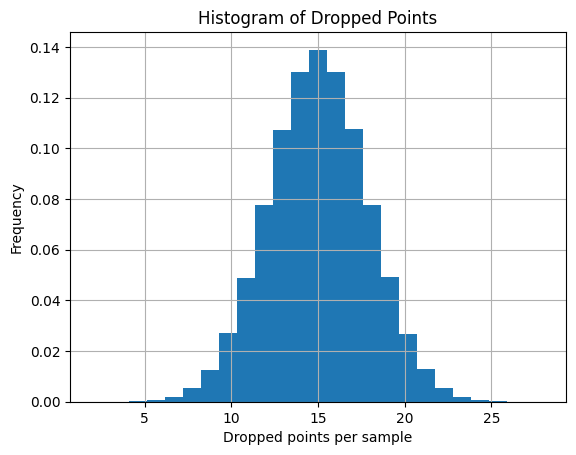

In [10]:
import matplotlib.pyplot as plt

plt.hist(all_drop_counts, bins=25, density=True)
plt.xlabel("Dropped points per sample")
plt.ylabel("Frequency")
plt.title("Histogram of Dropped Points")
plt.grid(True)
plt.show()

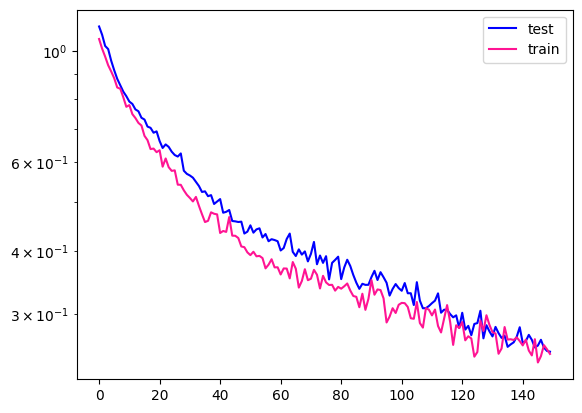

In [11]:
plt.plot(history_test, label='test', color='blue')
plt.plot(history_train, label='train', color='deeppink')

plt.yscale('log')
plt.legend()

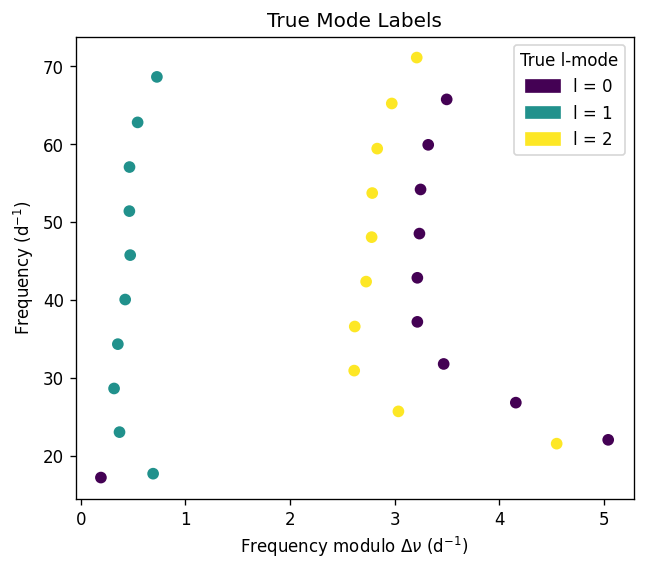

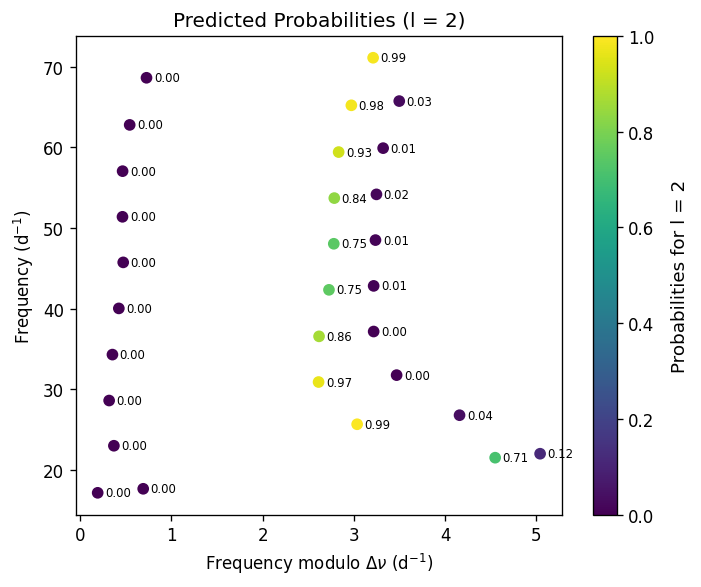

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
i_data = 50
l = 2  # which mode (l=0,1,2) to plot probability for

# Get the data
freqs = inpt.detach().numpy()[i_data, :, 1]
powers = inpt.detach().numpy()[i_data, :, 0]
true_labels = y_train.detach().numpy()[i_data]
probs = seg_out_test.exp().detach().numpy()[i_data, :, l]

# === First figure: True labels with custom legend ===
fig1 = plt.figure(figsize=(6, 5), dpi=120)
plt.scatter(freqs, powers, c=true_labels, cmap='viridis', vmin=0, vmax=2)

legend_elements = [
    mpatches.Patch(color=plt.cm.viridis(0.0), label='l = 0'),
    mpatches.Patch(color=plt.cm.viridis(0.5), label='l = 1'),
    mpatches.Patch(color=plt.cm.viridis(1.0), label='l = 2'),
]
plt.legend(handles=legend_elements, title="True l-mode", loc="upper right")
plt.title("True Mode Labels")
plt.xlabel(r"Frequency modulo $\Delta \nu$ (d$^{-1}$)")
plt.ylabel(r"Frequency (d$^{-1}$)")

# === Second figure: Predicted probability for l ===
fig2 = plt.figure(figsize=(6, 5), dpi=120)
sc = plt.scatter(freqs, powers, c=probs, cmap='viridis', vmin=0.0, vmax=1.0)

# Add text labels slightly to the right of each point
for x, y, p in zip(freqs, powers, probs):
    plt.text(x + 0.08, y, f"{p:.2f}", fontsize=7, color="black", ha='left', va='center')

cbar = plt.colorbar(sc)
cbar.set_label(f"Probabilities for l = {l}", fontsize=11, labelpad=10)
cbar.ax.tick_params(labelsize=10)
plt.title(f"Predicted Probabilities (l = {l})")
plt.xlabel(r"Frequency modulo $\Delta \nu$ (d$^{-1}$)")
plt.ylabel(r"Frequency (d$^{-1}$)")
plt.tight_layout()
plt.show()

In [23]:
loss_fn = nn.NLLLoss()
loss = loss_fn(seg_out_test.transpose(2,1), y_train[:size])

In [24]:
print(loss)

tensor(0.2522)


# NOW WE ADD THE DATA SHAKER BROOOO

#### kill me please (respectfully)

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# yeah abbreviated version of the other data dropper bc no commentary necessary anymore 
def apply_data_dropper(x, y, dropout_prob=0.5):
    mask = (torch.rand_like(x[:, :, 0]) > dropout_prob).long()
    x_dropped = x.clone()
    x_dropped[mask == 0] = 0.0
    y_dropped = y.clone()
    y_dropped[mask == 0] = -1
    drop_stats = mask.shape[1] - mask.sum(dim=1)
    return x_dropped, y_dropped, mask, drop_stats

def add_noise(x, noise_std=0.01):
    """
    teeny tiny RANDOM Gaussian noise to inputs.
    """
    noise = torch.randn_like(x) * noise_std
    return x + noise

# Training hyperparams
Nepoch = 150
nbatches = 100
learning_rate = 0.001
batch_size = inpt.size(0) // nbatches

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss(reduction="mean", ignore_index=-1)

history_train, history_test = [], []

# Data to evaluate on after each epoch
inpt_test = inpt
target_test = y_train[:inpt.shape[0]]
all_drop_counts = []

for epoch in range(Nepoch):
    model.train()

    for i in range(nbatches):
        optimizer.zero_grad()

        # Get the batch
        x_batch = inpt[i*batch_size:(i+1)*batch_size]
        y_batch = y_train[i*batch_size:(i+1)*batch_size]

        # Dropper
        x_dropped, y_dropped, mask, drop_stats = apply_data_dropper(x_batch, y_batch, dropout_prob=0.5)
        all_drop_counts.extend(drop_stats.cpu().tolist())

        # Apply Shaker (Noise)
        x_dropped = add_noise(x_dropped, noise_std=0.01)

        # Forward pass
        seg_output = model(x_dropped)
        cost = loss_fn(seg_output.permute(0, 2, 1), y_dropped)

        # Backward and optimize
        cost.backward()
        optimizer.step()

    # Eval after epoch
    model.eval()
    with torch.no_grad():
        seg_out_test = model(inpt_test)
        cost_test = loss_fn(seg_out_test.permute(0, 2, 1), target_test)

    history_train.append(float(cost))
    history_test.append(float(cost_test))

    print(f"Epoch {epoch}: Train Loss = {cost:.4f}, Test Loss = {cost_test:.4f}")


Epoch 0: Train Loss = 0.3127, Test Loss = 0.3047


KeyboardInterrupt: 

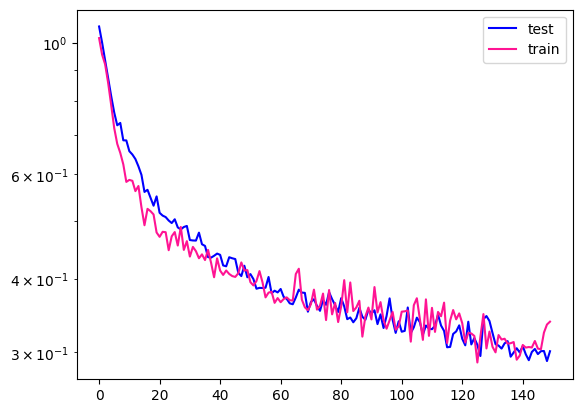

In [10]:
plt.plot(history_test, label='test', color='blue')
plt.plot(history_train, label='train', color='deeppink')

plt.yscale('log')
plt.legend()

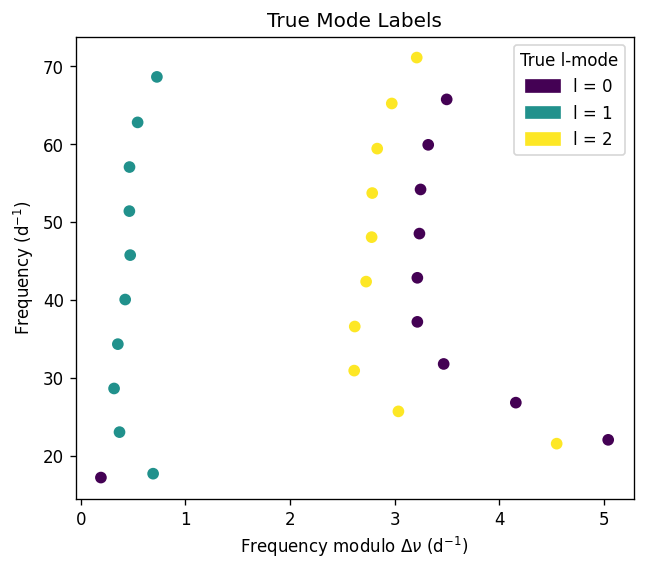

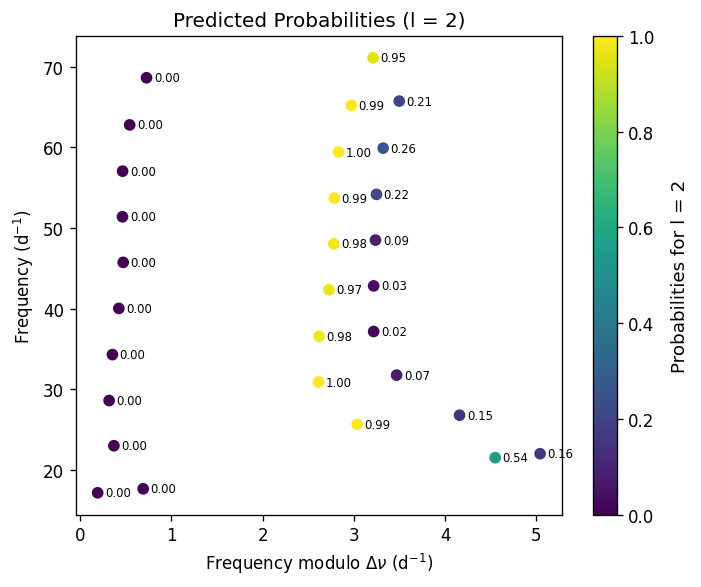

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
i_data = 50
l = 2  # which mode (l=0,1,2) to plot probability for

# Get the data
freqs = inpt.detach().numpy()[i_data, :, 1]
powers = inpt.detach().numpy()[i_data, :, 0]
true_labels = y_train.detach().numpy()[i_data]
probs = seg_out_test.exp().detach().numpy()[i_data, :, l]

# === First figure: True labels with custom legend ===
fig1 = plt.figure(figsize=(6, 5), dpi=120)
plt.scatter(freqs, powers, c=true_labels, cmap='viridis', vmin=0, vmax=2)

legend_elements = [
    mpatches.Patch(color=plt.cm.viridis(0.0), label='l = 0'),
    mpatches.Patch(color=plt.cm.viridis(0.5), label='l = 1'),
    mpatches.Patch(color=plt.cm.viridis(1.0), label='l = 2'),
]
plt.legend(handles=legend_elements, title="True l-mode", loc="upper right")
plt.title("True Mode Labels")
plt.xlabel(r"Frequency modulo $\Delta \nu$ (d$^{-1}$)")
plt.ylabel(r"Frequency (d$^{-1}$)")

# === Second figure: Predicted probability for l ===
fig2 = plt.figure(figsize=(6, 5), dpi=120)
sc = plt.scatter(freqs, powers, c=probs, cmap='viridis', vmin=0.0, vmax=1.0)

# Add text labels slightly to the right of each point
for x, y, p in zip(freqs, powers, probs):
    plt.text(x + 0.08, y, f"{p:.2f}", fontsize=7, color="black", ha='left', va='center')

cbar = plt.colorbar(sc)
cbar.set_label(f"Probabilities for l = {l}", fontsize=11, labelpad=10)
cbar.ax.tick_params(labelsize=10)
plt.title(f"Predicted Probabilities (l = {l})")
plt.xlabel(r"Frequency modulo $\Delta \nu$ (d$^{-1}$)")
plt.ylabel(r"Frequency (d$^{-1}$)")
plt.tight_layout()
plt.show()

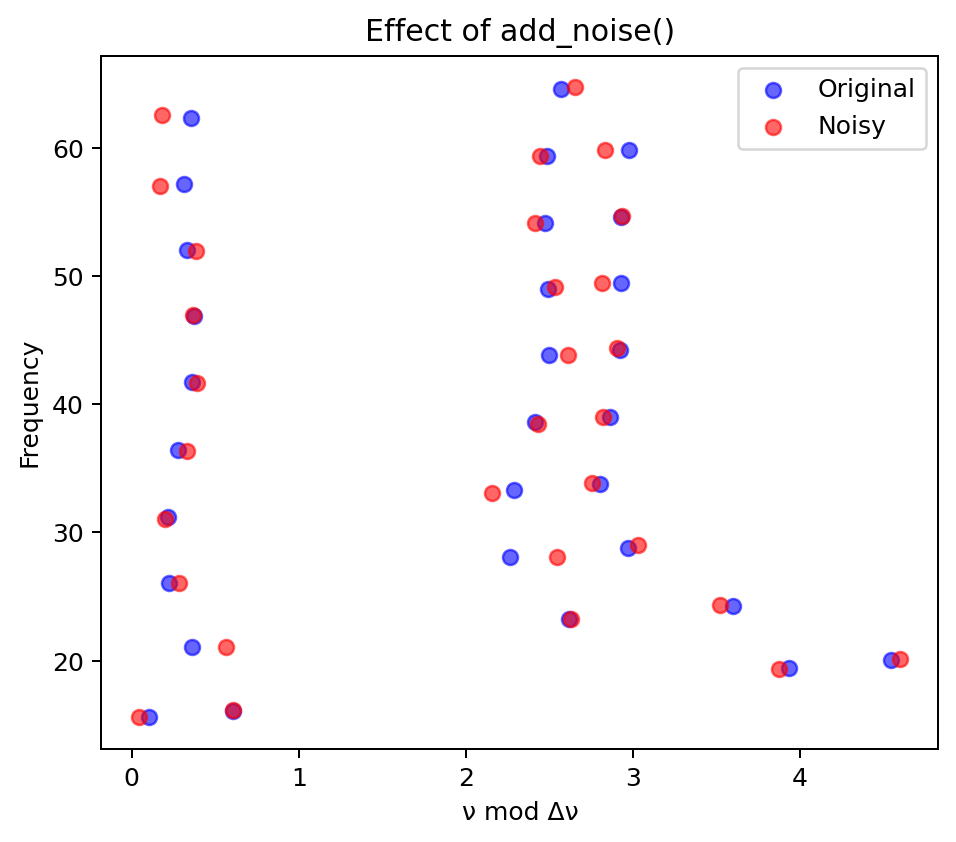

In [12]:
i = torch.randint(0, inpt.shape[0], (1,)).item()
x_orig = inpt[i].cpu()
x_noisy = add_noise(x_orig.unsqueeze(0)).squeeze(0).cpu()

fig1 = plt.figure(figsize=(6, 5), dpi=180)

plt.scatter(x_orig[:, 1], x_orig[:, 0], c='blue', label='Original', alpha=0.6)
plt.scatter(x_noisy[:, 1], x_noisy[:, 0], c='red', label='Noisy', alpha=0.6)
plt.xlabel("ν mod Δν")
plt.ylabel("Frequency")
plt.legend()
plt.title("Effect of add_noise()")
plt.show()

# NOW IT’S TIME FOR THE FAKERRRR WOHOOOooo… 
### omg kill me pls

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


def apply_data_dropper(x, y, dropout_prob=0.5):
    mask = (torch.rand_like(x[:, :, 0]) > dropout_prob).long()
    x_dropped = x.clone()
    x_dropped[mask == 0] = 0.0
    y_dropped = y.clone()
    y_dropped[mask == 0] = -1
    drop_stats = mask.shape[1] - mask.sum(dim=1)
    return x_dropped, y_dropped, mask, drop_stats


def add_noise(x, noise_std=0.01):
    noise = torch.randn_like(x) * noise_std
    return x + noise

def apply_data_faker(x, y, max_fakes=0.2):
    """
    Adds fake frequency points randomly within the frequency range of real data.
    Fake points have label = -1 (ignored in loss).
    """
    batch_size, num_points, _ = x.shape
    x_augmented, y_augmented = [], []

    for i in range(batch_size):
        xi, yi = x[i], y[i]

        valid_mask = yi != -1
        real_freqs = xi[valid_mask][:, 0]

        if len(real_freqs) < 2:
            x_augmented.append(xi)
            y_augmented.append(yi)
            continue

        min_f, max_f = real_freqs.min().item(), real_freqs.max().item()
        n_fake = torch.randint(2, int(num_points * max_fakes) + 1, (1,)).item() # questionable

        fake_freqs = torch.empty(n_fake).uniform_(min_f, max_f)
        fake_mods = fake_freqs % (max_f - min_f) # no bc delta nu needs to be calculated!
        fake_points = torch.stack((fake_freqs, fake_mods), dim=1)

        fake_labels = torch.full((n_fake,), -1, dtype=torch.long)  # label -1 = ignore

        x_augmented.append(torch.cat([xi, fake_points], dim=0))
        y_augmented.append(torch.cat([yi, fake_labels], dim=0))

    max_len = max([xi.shape[0] for xi in x_augmented])
    padded_x, padded_y = [], []

    for xi, yi in zip(x_augmented, y_augmented):
        pad_len = max_len - xi.shape[0]
        padded_x.append(F.pad(xi, (0, 0, 0, pad_len)))
        padded_y.append(F.pad(yi, (0, pad_len), value=-1))

    return torch.stack(padded_x), torch.stack(padded_y)
    
# Hyperparameters
Nepoch = 150
nbatches = 100
learning_rate = 0.001
batch_size = inpt.size(0) // nbatches

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss(reduction="mean", ignore_index=-1)

history_train, history_test = [], []

# Use full inpt as test reference
inpt_test = inpt
target_test = y_train[:inpt.shape[0]]

all_drop_counts = []

for epoch in range(Nepoch):
    model.train()

    for i in range(nbatches):
        optimizer.zero_grad()

        # Get batch
        x_batch = inpt[i*batch_size:(i+1)*batch_size]
        y_batch = y_train[i*batch_size:(i+1)*batch_size]

        # Drop real frequencies
        x_dropped, y_dropped, mask, drop_stats = apply_data_dropper(x_batch, y_batch, dropout_prob=0.5)
        all_drop_counts.extend(drop_stats.cpu().tolist())

        # Add fake frequencies
        x_fake, y_fake = apply_data_faker(x_dropped, y_dropped)

        # Add small noise
        x_noisy = add_noise(x_fake, noise_std=0.01)

        # Forward pass
        seg_output = model(x_noisy)
        cost = loss_fn(seg_output.permute(0, 2, 1), y_fake)

        # Backprop
        cost.backward()
        optimizer.step()

    # Evaluate
    model.eval()
    with torch.no_grad():
        seg_out_test = model(inpt_test)
        cost_test = loss_fn(seg_out_test.permute(0, 2, 1), target_test)

    history_train.append(float(cost))
    history_test.append(float(cost_test))

    print(f"Epoch {epoch}: Train Loss = {cost:.4f}, Test Loss = {cost_test:.4f}")

Epoch 0: Train Loss = 0.9482, Test Loss = 0.9727
Epoch 1: Train Loss = 0.9069, Test Loss = 0.9434
Epoch 2: Train Loss = 0.8874, Test Loss = 0.9194
Epoch 3: Train Loss = 0.8409, Test Loss = 0.8846
Epoch 4: Train Loss = 0.7873, Test Loss = 0.8888
Epoch 5: Train Loss = 0.7465, Test Loss = 0.7870
Epoch 6: Train Loss = 0.7176, Test Loss = 0.7876
Epoch 7: Train Loss = 0.6878, Test Loss = 0.7502
Epoch 8: Train Loss = 0.6564, Test Loss = 0.7444
Epoch 9: Train Loss = 0.6683, Test Loss = 0.7251
Epoch 10: Train Loss = 0.6361, Test Loss = 0.7169
Epoch 11: Train Loss = 0.6182, Test Loss = 0.7322
Epoch 12: Train Loss = 0.6026, Test Loss = 0.6979
Epoch 13: Train Loss = 0.6119, Test Loss = 0.6649
Epoch 14: Train Loss = 0.5974, Test Loss = 0.6701
Epoch 15: Train Loss = 0.5813, Test Loss = 0.6612
Epoch 16: Train Loss = 0.5623, Test Loss = 0.6331
Epoch 17: Train Loss = 0.5545, Test Loss = 0.6235
Epoch 18: Train Loss = 0.5523, Test Loss = 0.6668
Epoch 19: Train Loss = 0.5620, Test Loss = 0.6324
Epoch 20: 

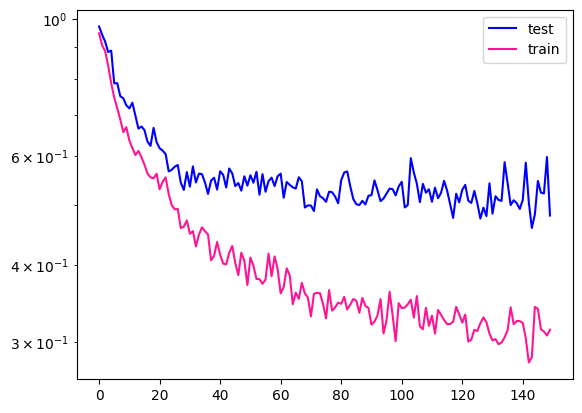

In [16]:
plt.plot(history_test, label='test', color='blue')
plt.plot(history_train, label='train', color='deeppink')

plt.yscale('log')
plt.legend()

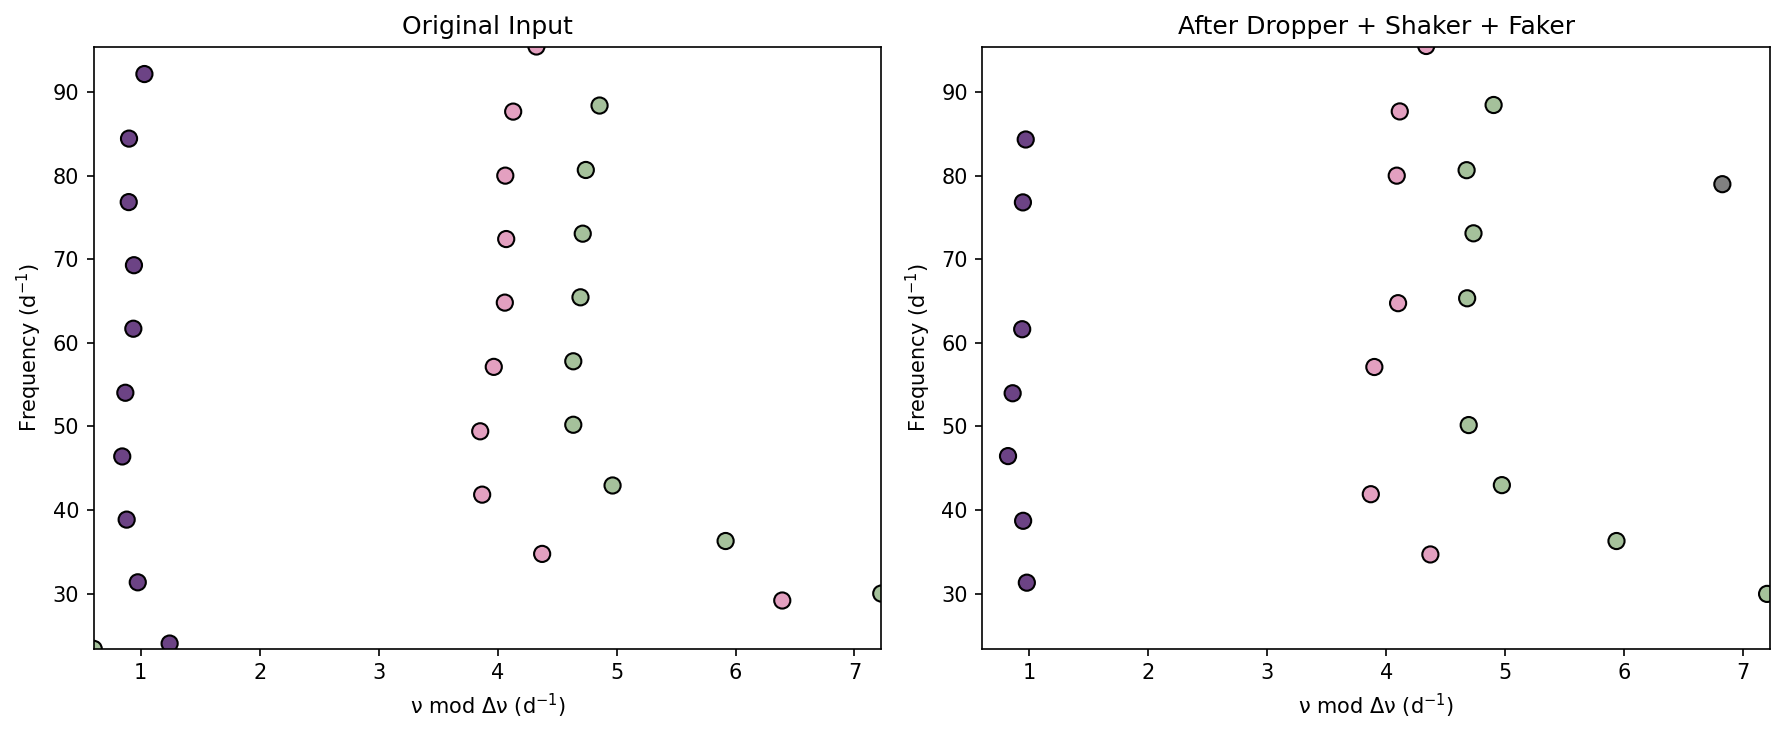

In [17]:
import matplotlib.pyplot as plt
import random
import torch

def apply_data_dropper(x, y, dropout_prob=0.5):
    mask = (torch.rand_like(x[:, :, 0]) > dropout_prob).long()
    x_dropped = x.clone()
    x_dropped[mask == 0] = 0.0
    y_dropped = y.clone()
    y_dropped[mask == 0] = -1
    drop_stats = mask.shape[1] - mask.sum(dim=1)
    return x_dropped, y_dropped, mask, drop_stats

def add_noise(x, noise_std=0.05):
    noise = torch.randn_like(x) * noise_std
    return x + noise

# Sample a random training example
rand_idx = random.randint(0, inpt.shape[0] - 1)
x_example = inpt[rand_idx:rand_idx+1]  # keep batch dim
y_example = y_train[rand_idx:rand_idx+1]

# Apply dropper
x_dropped, y_dropped, mask, _ = apply_data_dropper(x_example, y_example, dropout_prob=0.5)

# Apply shaker (noise)
x_shaken = add_noise(x_dropped, noise_std=0.05)

# Apply faker
x_faked, y_faked = apply_data_faker(x_shaken, y_dropped, max_fakes=5)

# Remove batch dim for plotting
x_orig = x_example.squeeze(0)
x_faked = x_faked.squeeze(0)
y_orig = y_example.squeeze(0)
y_faked = y_faked.squeeze(0)

# Define color map for l-modes (assuming labels 0,1,2 as example)
color_map = {0: '#a5c19b', 1: '#6c4385', 2: '#e3a0c0', -1: 'gray'}  # add gray for dropped/unknown
colors_orig = [color_map.get(int(l.item()), 'black') for l in y_orig]
colors_faked = [color_map.get(int(l.item()), 'black') for l in y_faked]

# Compute consistent axis limits
xlim = [x_orig[:, 1].min().item(), x_orig[:, 1].max().item()]
ylim = [x_orig[:, 0].min().item(), x_orig[:, 0].max().item()]

# Plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=150)

# Before any modification
axs[0].scatter(x_orig[:, 1], x_orig[:, 0], c=colors_orig, edgecolors='black', s=60)
axs[0].set_title("Original Input")
axs[0].set_xlabel("ν mod Δν (d$^{-1}$)")
axs[0].set_ylabel("Frequency (d$^{-1}$)")
axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)

# After dropper + shaker + faker
# Show only points where freq != 0 (dropper zeroed freq)
keep_mask = x_faked[:, 0] != 0
axs[1].scatter(x_faked[keep_mask, 1], x_faked[keep_mask, 0],
               c=[colors_faked[i] for i in range(len(colors_faked)) if keep_mask[i]],
               edgecolors='black', s=60)
axs[1].set_title("After Dropper + Shaker + Faker")
axs[1].set_xlabel("ν mod Δν (d$^{-1}$)")
axs[1].set_ylabel("Frequency (d$^{-1}$)")
axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)

plt.tight_layout()
plt.show()

# ONLY FAKER

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# up to about 20% fake points relative to the number of real points per sample
def apply_data_faker(x, y, max_fakes=0.2):
    """
    Adds fake frequency points randomly within the frequency range of real data.
    Fake points have label = -1 (ignored in loss).
    """
    batch_size, num_points, _ = x.shape
    x_augmented, y_augmented = [], []

    for i in range(batch_size): # just iterating over items
        xi, yi = x[i], y[i]

        valid_mask = yi != -1 # finding valid, i.e. not dropped points!
        real_freqs = xi[valid_mask][:, 0]

        if len(real_freqs) < 2: # if there aren't enough real points to define a range we skip
            x_augmented.append(xi)
            y_augmented.append(yi)
            continue

        min_f, max_f = real_freqs.min().item(), real_freqs.max().item()
        n_fake = torch.randint(2, int(num_points * max_fakes) + 1, (1,)).item() # SAMPLE NUMBER OF FAKE POINTS!

        fake_freqs = torch.empty(n_fake).uniform_(min_f, max_f) # now generating the fake freqs, modulo values and together the points!
        fake_mods = fake_freqs % (max_f - min_f) 
        fake_points = torch.stack((fake_freqs, fake_mods), dim=1)

        fake_labels = torch.full((n_fake,), -1, dtype=torch.long)  # ignored by loss

        x_augmented.append(torch.cat([xi, fake_points], dim=0)) # concatenate stuff
        y_augmented.append(torch.cat([yi, fake_labels], dim=0))

    max_len = max([xi.shape[0] for xi in x_augmented])
    padded_x, padded_y = [], []

    for xi, yi in zip(x_augmented, y_augmented):
        pad_len = max_len - xi.shape[0]
        padded_x.append(F.pad(xi, (0, 0, 0, pad_len)))       # pad along point dimension
        padded_y.append(F.pad(yi, (0, pad_len), value=-1))   # pad labels with -1

    return torch.stack(padded_x), torch.stack(padded_y)

Nepoch = 150
nbatches = 100
learning_rate = 0.001
batch_size = inpt.size(0) // nbatches

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss(reduction="mean", ignore_index=-1)

history_train, history_test = [], []

# Use full input as test reference
inpt_test = inpt
target_test = y_train[:inpt.shape[0]]

for epoch in range(Nepoch):
    model.train()

    for i in range(nbatches):
        optimizer.zero_grad()

        # Get batch
        x_batch = inpt[i*batch_size:(i+1)*batch_size]
        y_batch = y_train[i*batch_size:(i+1)*batch_size]

        # Add fake frequencies
        x_fake, y_fake = apply_data_faker(x_batch, y_batch, max_fakes=0.2)

        # Forward pass
        seg_output = model(x_fake)  # output shape: [B, num_points, 3]
        cost = loss_fn(seg_output.permute(0, 2, 1), y_fake)

        # Backprop
        cost.backward()
        optimizer.step()

    # Evaluate
    model.eval()
    with torch.no_grad():
        seg_out_test = model(inpt_test)
        cost_test = loss_fn(seg_out_test.permute(0, 2, 1), target_test)

    history_train.append(float(cost))
    history_test.append(float(cost_test))

    print(f"Epoch {epoch}: Train Loss = {cost:.4f}, Test Loss = {cost_test:.4f}")


Epoch 0: Train Loss = 1.0745, Test Loss = 1.0857
Epoch 1: Train Loss = 1.0432, Test Loss = 1.0500
Epoch 2: Train Loss = 1.0022, Test Loss = 1.0010
Epoch 3: Train Loss = 0.9548, Test Loss = 0.9409
Epoch 4: Train Loss = 0.9159, Test Loss = 0.8951
Epoch 5: Train Loss = 0.8611, Test Loss = 0.8418
Epoch 6: Train Loss = 0.8218, Test Loss = 0.7966
Epoch 7: Train Loss = 0.7852, Test Loss = 0.7623
Epoch 8: Train Loss = 0.7584, Test Loss = 0.7358
Epoch 9: Train Loss = 0.7312, Test Loss = 0.7071
Epoch 10: Train Loss = 0.6981, Test Loss = 0.6654
Epoch 11: Train Loss = 0.6614, Test Loss = 0.6330
Epoch 12: Train Loss = 0.6295, Test Loss = 0.6100
Epoch 13: Train Loss = 0.6029, Test Loss = 0.5833
Epoch 14: Train Loss = 0.5828, Test Loss = 0.5599
Epoch 15: Train Loss = 0.5571, Test Loss = 0.5446
Epoch 16: Train Loss = 0.5468, Test Loss = 0.5315
Epoch 17: Train Loss = 0.5299, Test Loss = 0.5180
Epoch 18: Train Loss = 0.5277, Test Loss = 0.5027
Epoch 19: Train Loss = 0.5051, Test Loss = 0.5008
Epoch 20: 

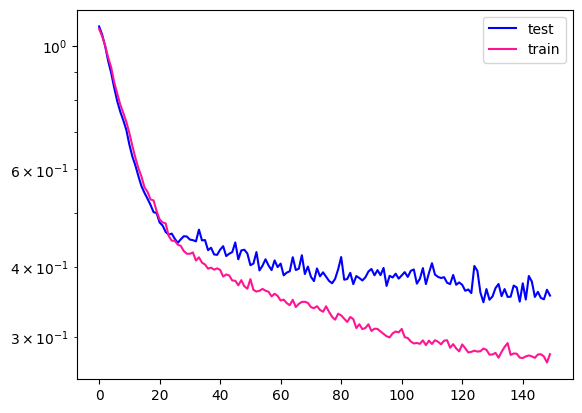

In [10]:
plt.plot(history_test, label='test', color='blue')
plt.plot(history_train, label='train', color='deeppink')

plt.yscale('log')
plt.legend()